# 0. Import Requirements

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import re
import contractions
import string
nltk.download('stopwords')
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statistics import mean
import math
from lazypredict.Supervised import LazyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df = train_df.iloc[np.r_[0:1500, -1500:0]]
train_df = train_df.sample(frac=1).reset_index(drop = True)

# 1. Exploratory Data Analysis

## Training Dataset

In [4]:
print("Size of dataset:", train_df.shape[0])
print(f"Positive sentiment: {train_df.Sentiment.value_counts()[1] / train_df.shape[0] * 100} %")
print(f"Negative sentiment: {100 - train_df.Sentiment.value_counts()[1] / train_df.shape[0] * 100} %")
print(f"Text with no sentiment: {train_df.shape[0] - train_df.Sentiment.value_counts()[0] - train_df.Sentiment.value_counts()[1]}")
train_df.head()

Size of dataset: 3000
Positive sentiment: 50.0 %
Negative sentiment: 50.0 %
Text with no sentiment: 0


,Index,Sentiment,Text
0,1047650,1,@Falkork yea thanks already tried personas. R...
1,87,0,My tummy hurts. I wonder if the hypnosis has ...
2,910,0,@Sephystryx I've been looking about for good s...
3,1047114,1,"@melodysong jeez, not my fault that you weren'..."
4,327,0,..and of course... I have access to my Halo 3 ...


## Testing Dataset

In [5]:
print("Size of dataset:", test_df.shape[0])
print(f"Positive sentiment: {test_df.Sentiment.value_counts()[1] / test_df.shape[0] * 100} %")
print(f"Negative sentiment: {100 - test_df.Sentiment.value_counts()[1] / test_df.shape[0] * 100} %")
print(f"Text with no sentiment: {test_df.shape[0] - test_df.Sentiment.value_counts()[0] - test_df.Sentiment.value_counts()[1]}")
test_df.head()

Size of dataset: 359
Positive sentiment: 50.69637883008357 %
Negative sentiment: 49.30362116991643 %
Text with no sentiment: 0


,Index,Sentiment,Text
0,0,1,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,1,Reading my kindle2... Love it... Lee childs i...
2,2,1,"Ok, first assesment of the #kindle2 ...it fuck..."
3,3,1,@kenburbary You'll love your Kindle2. I've had...
4,4,1,@mikefish Fair enough. But i have the Kindle2...


# 2. Text Preprocessing

In [6]:
def preprocess_text(input_df):
    input_df["tokens"] = input_df["Text"].apply(lambda x: nltk.tokenize.sent_tokenize(x))
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y.lower() for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [re.sub('[0-9]', '', y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [contractions.fix(y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y.translate(str.maketrans('', '', string.punctuation)) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [nltk.tokenize.word_tokenize(y) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [list(filter(lambda y: y not in set(nltk.corpus.stopwords.words('english')), y)) for y in x])
    input_df["tokens"] = input_df["tokens"].apply(lambda x: [y for y in x if y != []])
    return input_df

In [7]:
train_df = preprocess_text(train_df)
test_df = preprocess_text(test_df)

# 3. Linguistic Feature Extraction

## Word2Vec

In [8]:
def train_word2vec(sentences):
    model = Word2Vec(min_count=0)
    model.build_vocab(sentences, update=False)
    return model

In [9]:
train_sent_df = [y for x in train_df["tokens"] for y in x]
trained_word2vec_model = train_word2vec(train_sent_df)

In [10]:
x_train_word2vec = []
y_train_word2vec = []

x_temp = []

for idx, row in train_df.iterrows():
    for s in row["tokens"]:
        for w in s:
            if w in trained_word2vec_model.wv:
                x_temp.append(trained_word2vec_model.wv[w])
        x_train_word2vec.append(np.mean(np.array(x_temp), axis=0).tolist())
        y_train_word2vec.append(row["Sentiment"])
        x_temp = []
                

In [11]:
x_test_word2vec = []
y_test_word2vec = []

x_temp = []

for idx, row in test_df.iterrows():
    for s in row["tokens"]:
        for w in s:
            if w in trained_word2vec_model.wv:
                x_temp.append(trained_word2vec_model.wv[w])
        app = np.mean(np.array(x_temp), axis=0).tolist()
        if isinstance(app, list) or not math.isnan(app):
            x_test_word2vec.append(app)
            y_test_word2vec.append(row["Sentiment"])
        x_temp = []

## Bag of Words

In [12]:
vectorizer = CountVectorizer()

In [13]:
train_sent_df = []
test_sent_df = []

In [14]:
x_train_BoW = []
y_train_BoW = []

for idx, row in train_df.iterrows():
    for s in row["tokens"]:
        train_sent_df.append((np.array(' '.join(s))).tolist())
        y_train_BoW.append(row["Sentiment"])
              
x_train_BoW = vectorizer.fit_transform(train_sent_df)

In [15]:
x_test_BoW = []
y_test_BoW = []

for idx, row in test_df.iterrows():
    for s in row["tokens"]:
        test_sent_df.append((np.array(' '.join(s))).tolist())
        y_test_BoW.append(row["Sentiment"])
        
x_test_BoW = vectorizer.transform(test_sent_df)

## TF-IDF

In [16]:
vectorizer = TfidfVectorizer()

In [17]:
x_train_tfidf = vectorizer.fit_transform(train_sent_df)
y_train_tfidf = y_train_BoW

In [18]:
x_test_tfidf = vectorizer.transform(test_sent_df)
y_test_tfidf = y_test_BoW

# 4. Build your sentiment classification model

In [19]:
models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest']
classifier_names = ['precision score', 'recall score', 'f1 score', 'accuracy score']
linguistic_features_names = ['Word2Vec', 'Bag of Words', 'TF-IDF']

In [20]:
lc = LogisticRegression()
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

## Word2Vec

In [21]:
lc.fit(pd.DataFrame(x_train_word2vec), pd.DataFrame(y_train_word2vec))
print("Linear Classifier done ...")
svc.fit(pd.DataFrame(x_train_word2vec), pd.DataFrame(y_train_word2vec))
print("SVM Classifier done ...")
nbc.fit(pd.DataFrame(x_train_word2vec), pd.DataFrame(y_train_word2vec))
print("Naive Bayes Classifier done ...")
rfc.fit(pd.DataFrame(x_train_word2vec), pd.DataFrame(y_train_word2vec))
print("Random Forest Classifier done ...")

Linear Classifier done ...
SVM Classifier done ...
Naive Bayes Classifier done ...
Random Forest Classifier done ...


In [22]:
pred_word2vec = [lc.predict(pd.DataFrame(x_test_word2vec)), svc.predict(pd.DataFrame(x_test_word2vec)), nbc.predict(pd.DataFrame(x_test_word2vec)), rfc.predict(pd.DataFrame(x_test_word2vec))]
pred_proba_word2vec = [lc.predict_proba(pd.DataFrame(x_test_word2vec)), svc.predict_proba(pd.DataFrame(x_test_word2vec)), nbc.predict_proba(pd.DataFrame(x_test_word2vec)), rfc.predict_proba(pd.DataFrame(x_test_word2vec))]

In [23]:
accuracies = [accuracy_score(y_test_word2vec, y_pred) for y_pred in pred_word2vec]
precisions = [precision_score(y_test_word2vec, y_pred, average="weighted") for y_pred in pred_word2vec]
recalls = [recall_score(y_test_word2vec, y_pred, average="weighted") for y_pred in pred_word2vec]
f1_scores = [f1_score(y_test_word2vec, y_pred, average="weighted") for y_pred in pred_word2vec]

classifiers_word2vec = [accuracies, precisions, recalls, f1_scores]

## Bag of Words

In [24]:
lc.fit(pd.DataFrame(x_train_BoW.toarray()), pd.DataFrame(y_train_BoW))
print("Linear Classifier done ...")
svc.fit(pd.DataFrame(x_train_BoW.toarray()), pd.DataFrame(y_train_BoW))
print("SVM Classifier done ...")
nbc.fit(pd.DataFrame(x_train_BoW.toarray()), pd.DataFrame(y_train_BoW))
print("Naive Bayes Classifier done ...")
rfc.fit(pd.DataFrame(x_train_BoW.toarray()), pd.DataFrame(y_train_BoW))
print("Random Forest Classifier done ...")

Linear Classifier done ...
SVM Classifier done ...
Naive Bayes Classifier done ...
Random Forest Classifier done ...


In [25]:
pred_BoW = [lc.predict(pd.DataFrame(x_test_BoW.toarray())), svc.predict(pd.DataFrame(x_test_BoW.toarray())), nbc.predict(pd.DataFrame(x_test_BoW.toarray())), rfc.predict(pd.DataFrame(x_test_BoW.toarray()))]
pred_proba_BoW = [lc.predict_proba(pd.DataFrame(x_test_BoW.toarray())), svc.predict_proba(pd.DataFrame(x_test_BoW.toarray())), nbc.predict_proba(pd.DataFrame(x_test_BoW.toarray())), rfc.predict_proba(pd.DataFrame(x_test_BoW.toarray()))]

In [26]:
accuracies = [accuracy_score(y_test_BoW, y_pred) for y_pred in pred_BoW]
precisions = [precision_score(y_test_BoW, y_pred, average="weighted") for y_pred in pred_BoW]
recalls = [recall_score(y_test_BoW, y_pred, average="weighted") for y_pred in pred_BoW]
f1_scores = [f1_score(y_test_BoW, y_pred, average="weighted") for y_pred in pred_BoW]

classifiers_BoW = [accuracies, precisions, recalls, f1_scores]

## TF-IDF

In [27]:
lc.fit(pd.DataFrame(x_train_tfidf.toarray()), pd.DataFrame(y_train_tfidf))
print("Linear Classifier done ...")
svc.fit(pd.DataFrame(x_train_tfidf.toarray()), pd.DataFrame(y_train_tfidf))
print("SVM Classifier done ...")
nbc.fit(pd.DataFrame(x_train_tfidf.toarray()), pd.DataFrame(y_train_tfidf))
print("Naive Bayes Classifier done ...")
rfc.fit(pd.DataFrame(x_train_tfidf.toarray()), pd.DataFrame(y_train_tfidf))
print("Random Forest Classifier done ...")

Linear Classifier done ...
SVM Classifier done ...
Naive Bayes Classifier done ...
Random Forest Classifier done ...


In [28]:
pred_tfidf = [lc.predict(pd.DataFrame(x_test_tfidf.toarray())), svc.predict(pd.DataFrame(x_test_tfidf.toarray())), nbc.predict(pd.DataFrame(x_test_tfidf.toarray())), rfc.predict(pd.DataFrame(x_test_tfidf.toarray()))]
pred_proba_tfidf = [lc.predict_proba(pd.DataFrame(x_test_tfidf.toarray())), svc.predict_proba(pd.DataFrame(x_test_tfidf.toarray())), nbc.predict_proba(pd.DataFrame(x_test_tfidf.toarray())), rfc.predict_proba(pd.DataFrame(x_test_tfidf.toarray()))]

In [29]:
accuracies = [accuracy_score(y_test_tfidf, y_pred) for y_pred in pred_tfidf]
precisions = [precision_score(y_test_tfidf, y_pred, average="weighted") for y_pred in pred_tfidf]
recalls = [recall_score(y_test_tfidf, y_pred, average="weighted") for y_pred in pred_tfidf]
f1_scores = [f1_score(y_test_tfidf, y_pred, average="weighted") for y_pred in pred_tfidf]

classifiers_tfidf = [accuracies, precisions, recalls, f1_scores]

# 5. Model evaluation

## Comparing models for same linguistic feature extraction

### Word2Vec

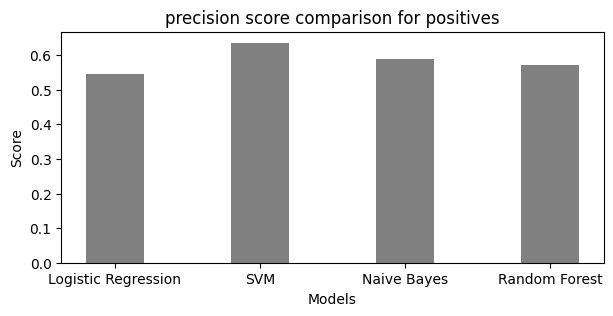

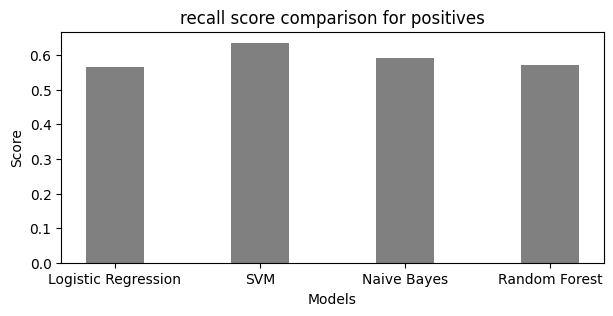

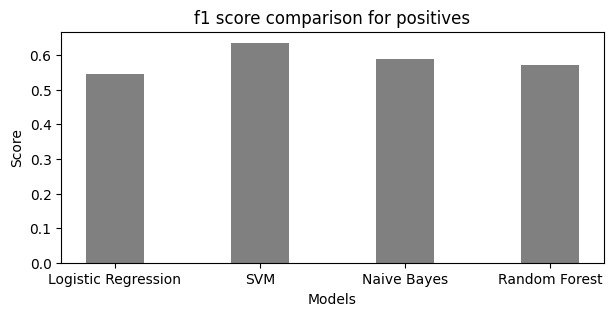

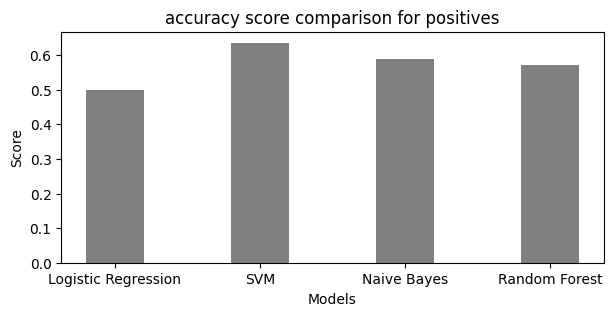

In [30]:
for classifier, classifier_name in zip(classifiers_word2vec, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(models, classifier, color ='gray', width = 0.4)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

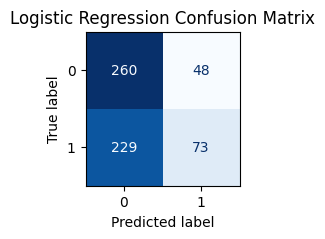

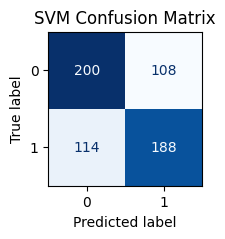

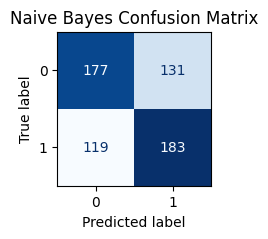

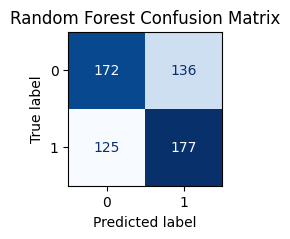

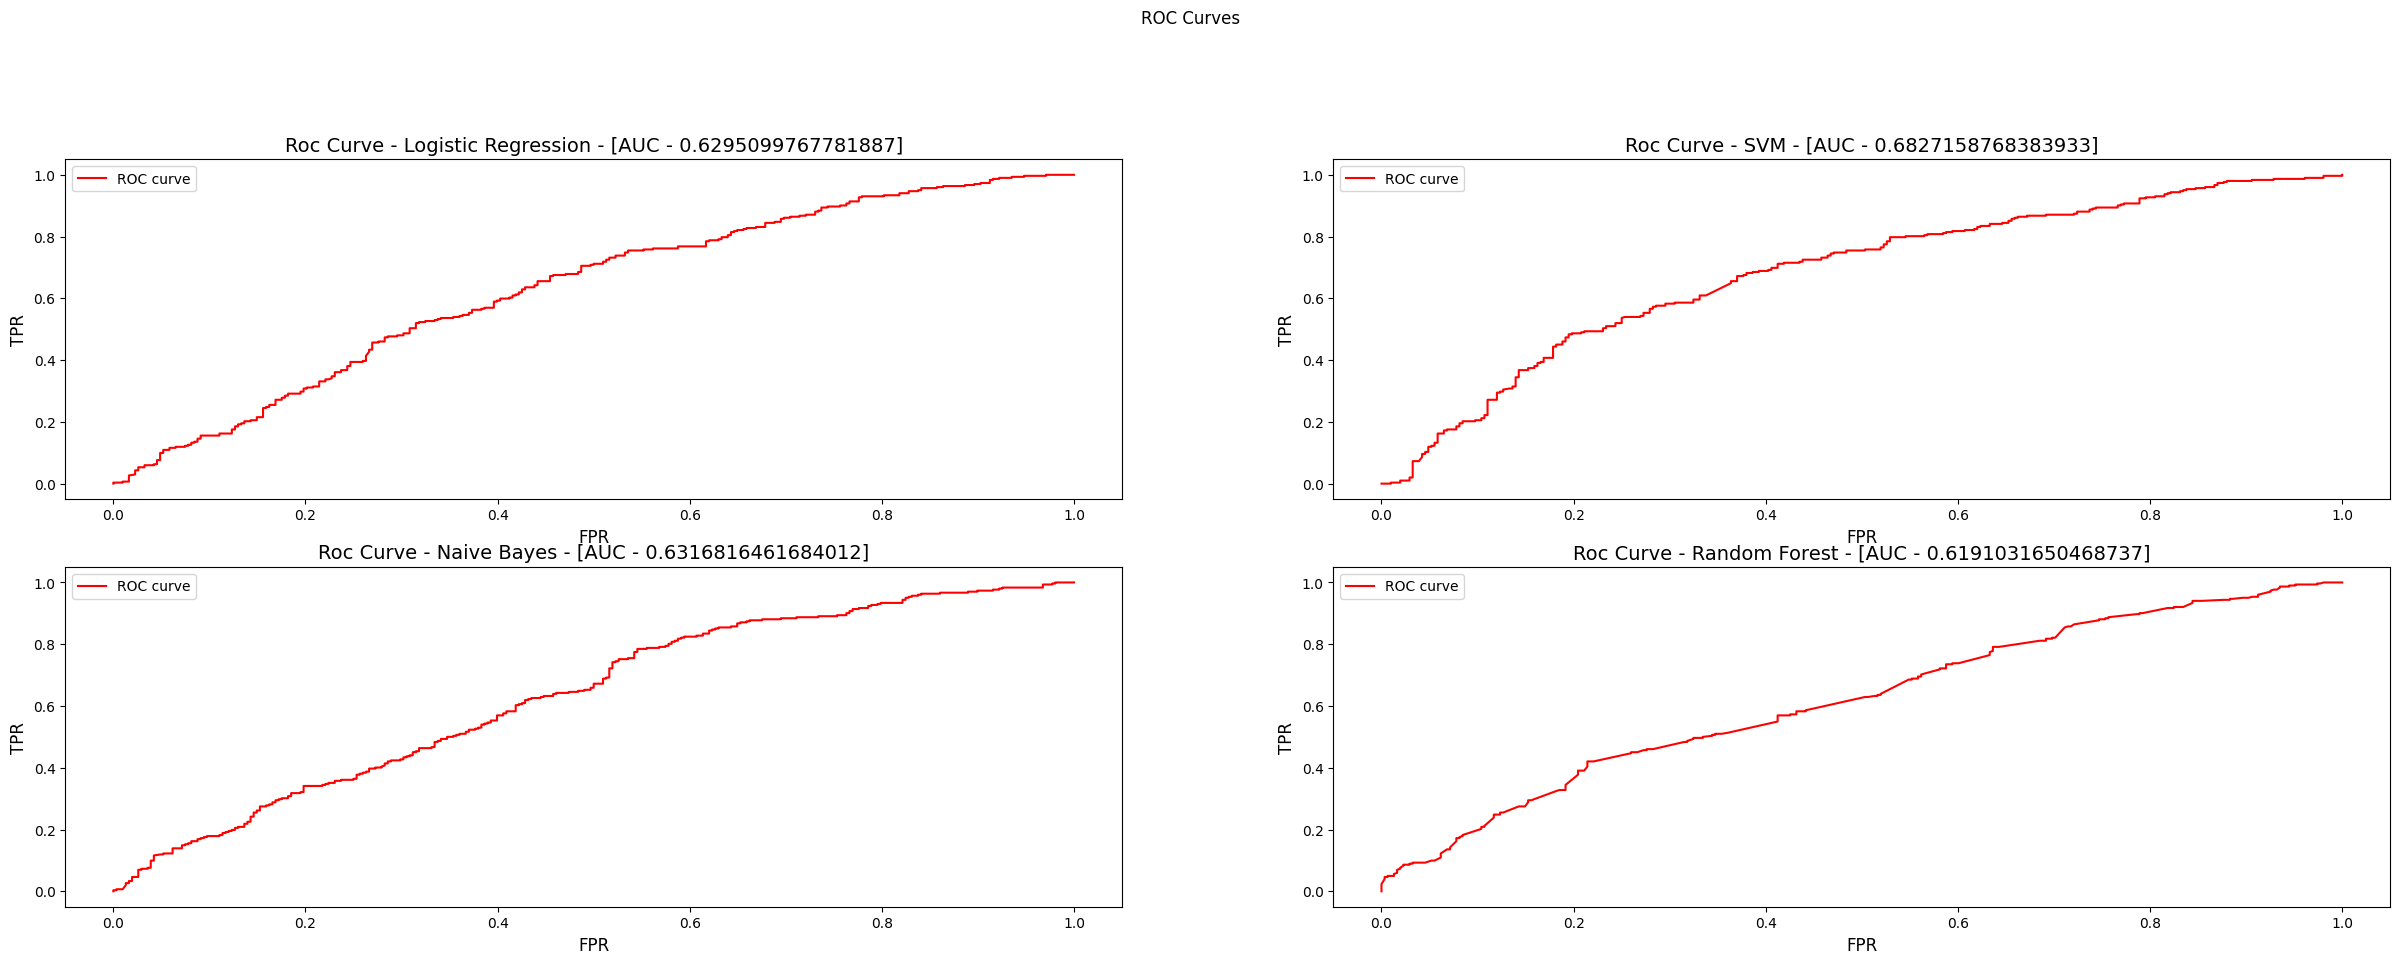

In [31]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

for model, prediction, pred_proba in zip(models, pred_word2vec, pred_proba_word2vec):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test_word2vec).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, pred_word2vec, pred_proba_word2vec):
    fpr, tpr, thresholds = roc_curve(np.array(y_test_word2vec), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### Bag of Words

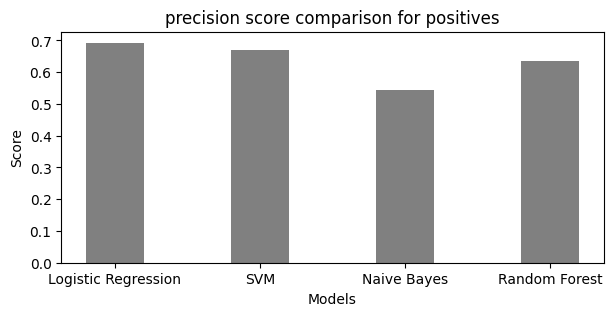

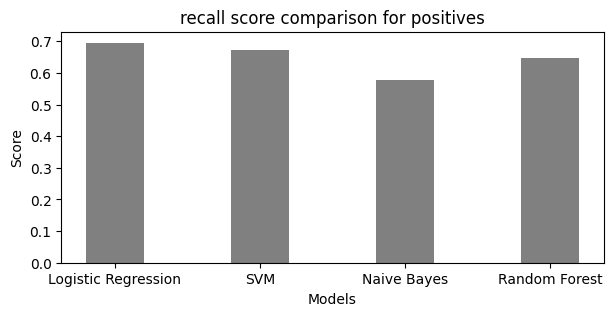

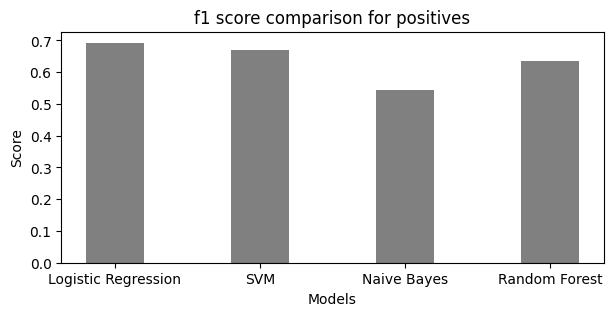

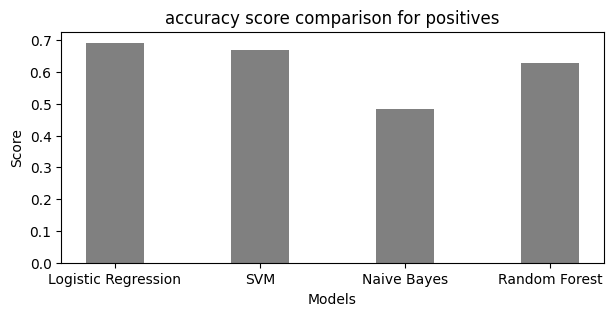

In [32]:
for classifier, classifier_name in zip(classifiers_BoW, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(models, classifier, color ='gray', width = 0.4)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

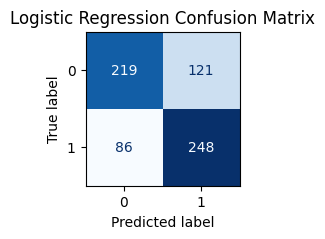

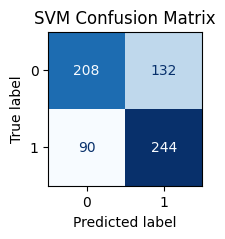

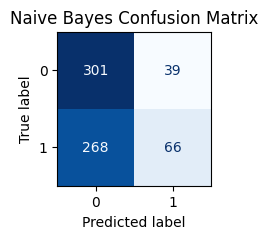

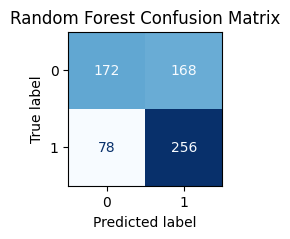

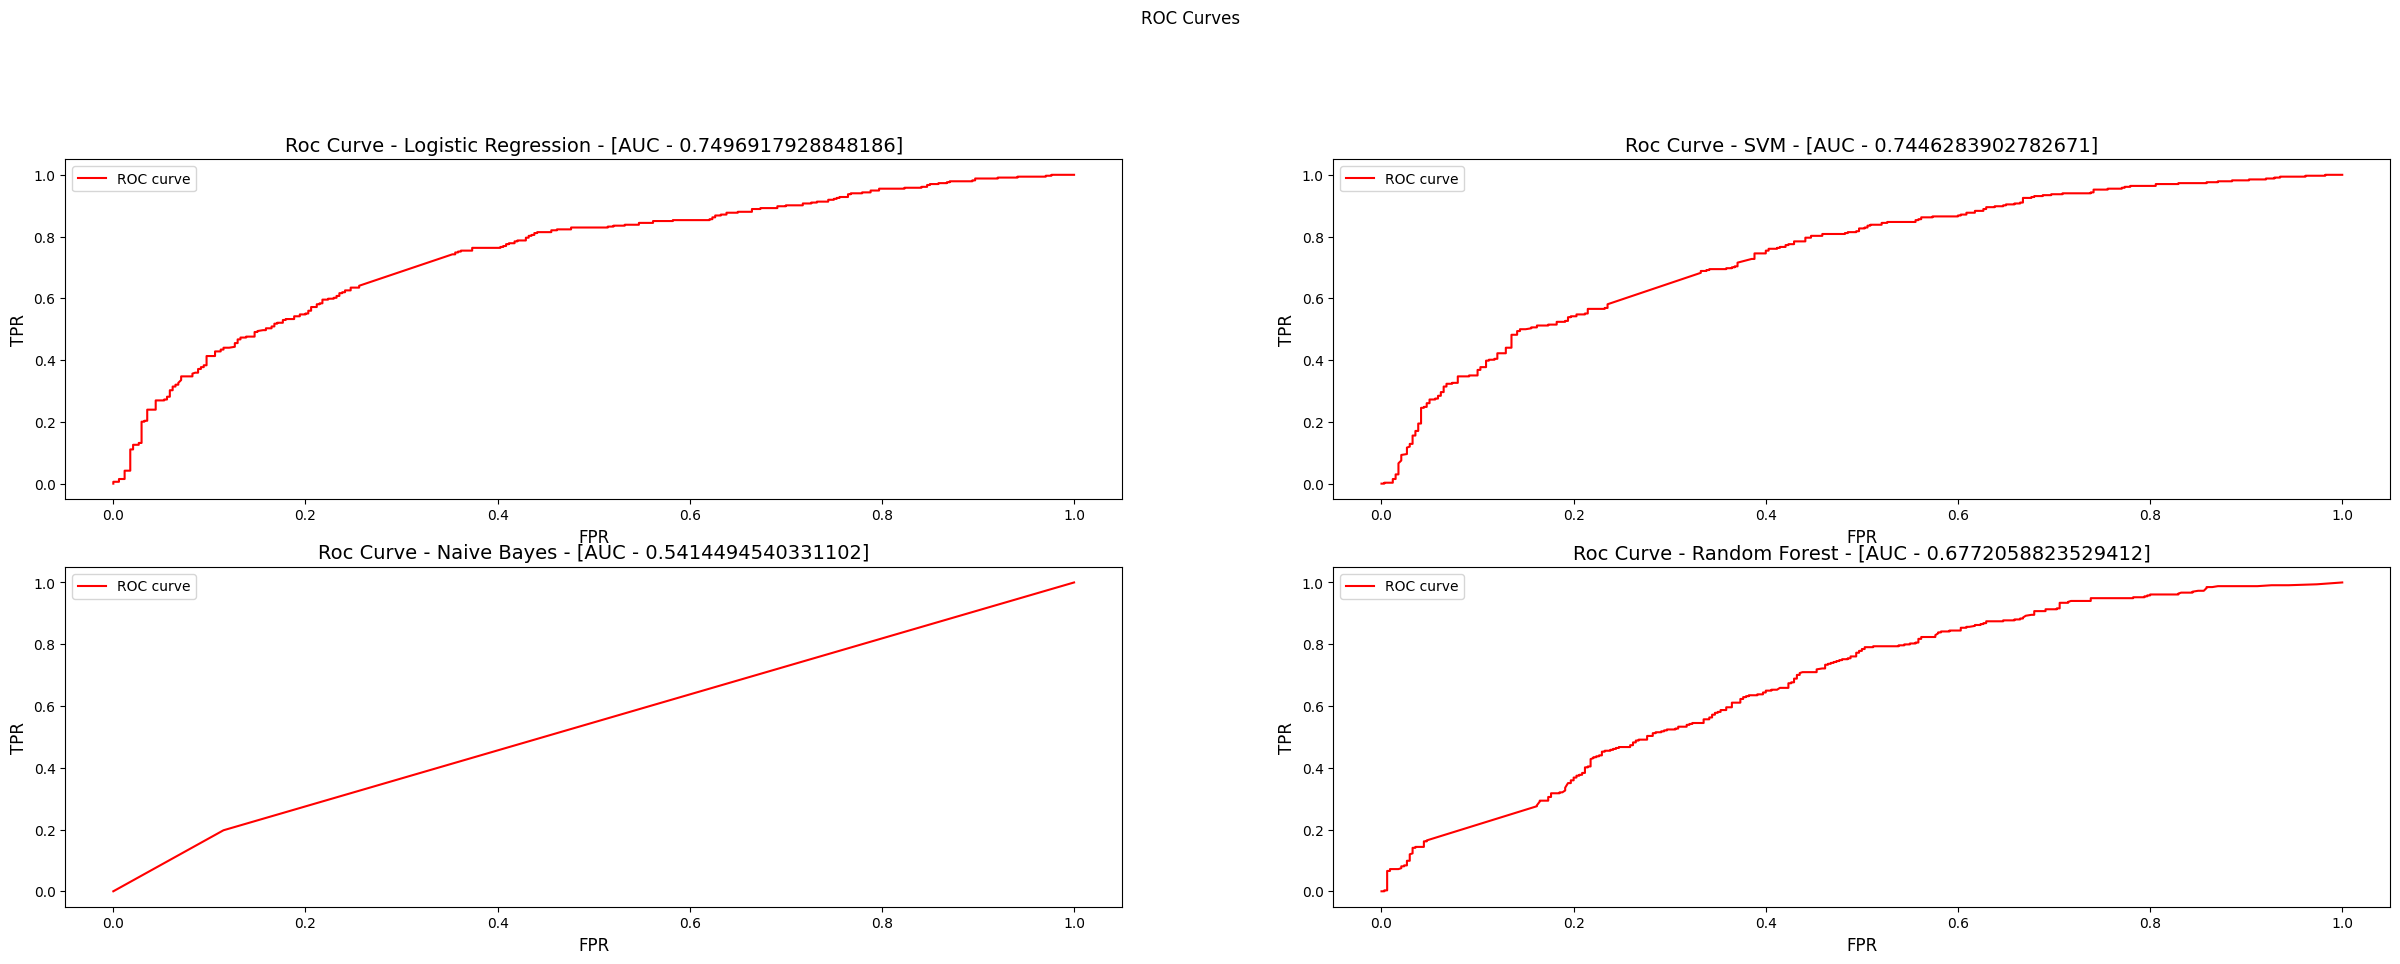

In [33]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

for model, prediction, pred_proba in zip(models, pred_BoW, pred_proba_BoW):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test_BoW).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, pred_BoW, pred_proba_BoW):
    fpr, tpr, thresholds = roc_curve(np.array(y_test_BoW), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### TF-IDF

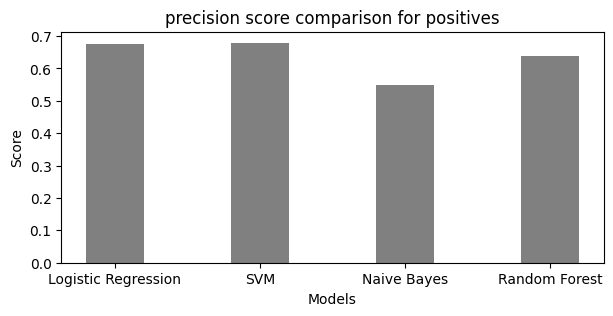

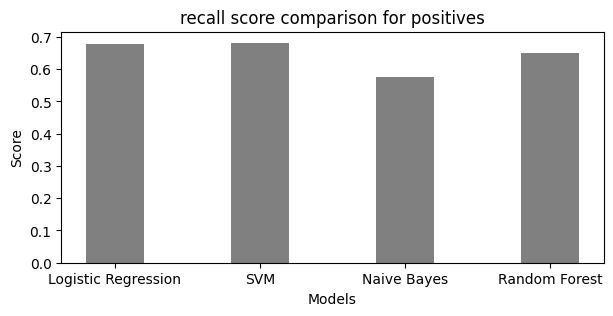

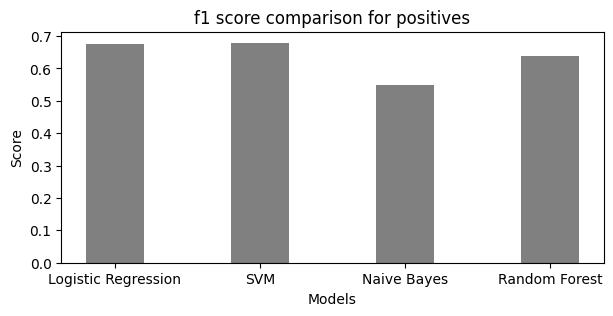

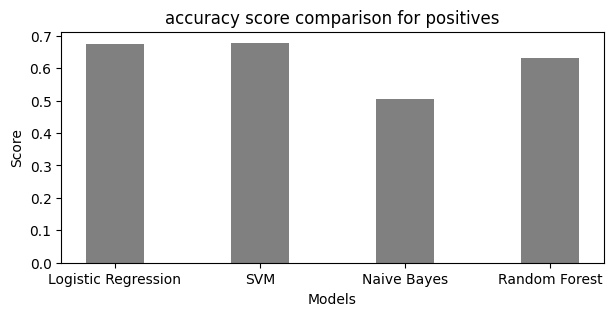

In [34]:
for classifier, classifier_name in zip(classifiers_tfidf, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(models, classifier, color ='gray', width = 0.4)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

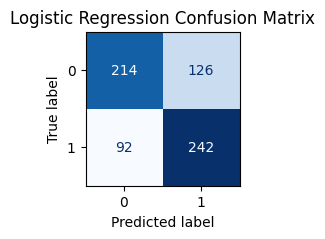

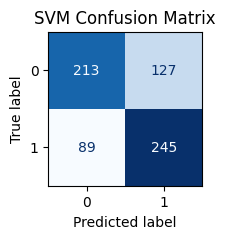

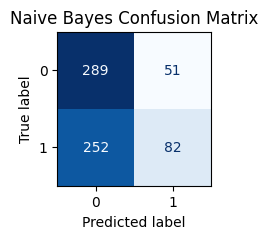

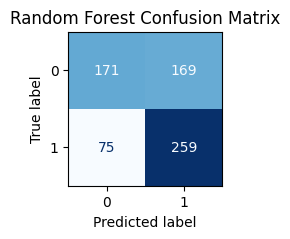

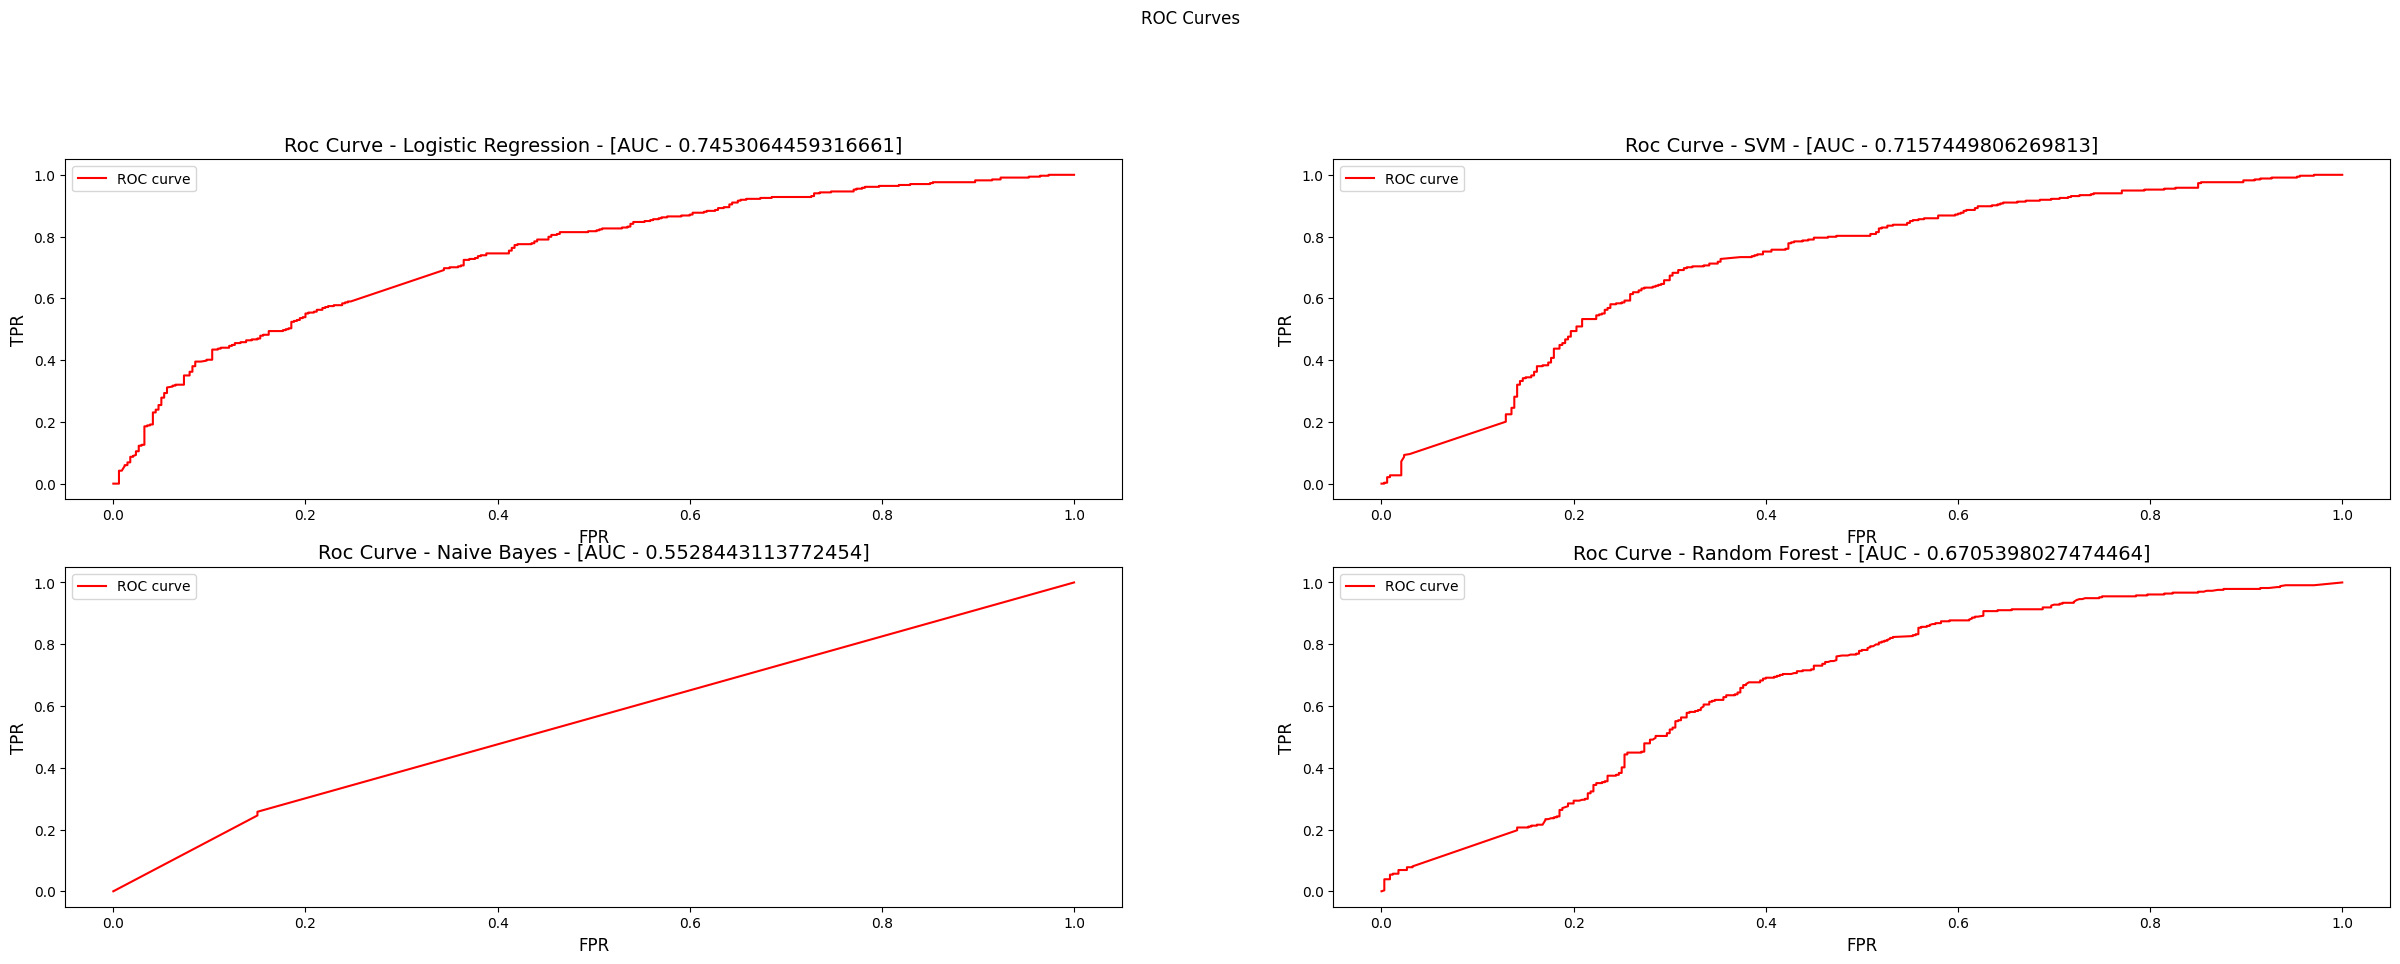

In [35]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

for model, prediction, pred_proba in zip(models, pred_tfidf, pred_proba_tfidf):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test_tfidf).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, pred_tfidf, pred_proba_tfidf):
    fpr, tpr, thresholds = roc_curve(np.array(y_test_tfidf), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

## Comparing linguistic feature extraction for same models 

In [36]:
lc_classifiers = [[x[0][y] for x in [classifiers_word2vec, classifiers_BoW, classifiers_tfidf]] for y in range(4)]
svc_classifiers = [[x[1][y] for x in [classifiers_word2vec, classifiers_BoW, classifiers_tfidf]] for y in range(4)]
nbc_classifiers = [[x[2][y] for x in [classifiers_word2vec, classifiers_BoW, classifiers_tfidf]] for y in range(4)]
rfc_classifiers = [[x[3][y] for x in [classifiers_word2vec, classifiers_BoW, classifiers_tfidf]] for y in range(4)]

In [37]:
lc_pred = [x[0] for x in [pred_word2vec, pred_BoW, pred_tfidf]]
svc_pred = [x[1] for x in [pred_word2vec, pred_BoW, pred_tfidf]]
nbc_pred = [x[2] for x in [pred_word2vec, pred_BoW, pred_tfidf]]
rfc_pred = [x[3] for x in [pred_word2vec, pred_BoW, pred_tfidf]]

In [38]:
lc_pred_proba = [x[0] for x in [pred_proba_word2vec, pred_proba_BoW, pred_proba_tfidf]]
svc_pred_proba = [x[1] for x in [pred_proba_word2vec, pred_proba_BoW, pred_proba_tfidf]]
nbc_pred_proba = [x[2] for x in [pred_proba_word2vec, pred_proba_BoW, pred_proba_tfidf]]
rfc_pred_proba = [x[3] for x in [pred_proba_word2vec, pred_proba_BoW, pred_proba_tfidf]]

In [39]:
lf_y_test = [y_test_word2vec, y_test_BoW, y_test_tfidf]

### Logistic Regression

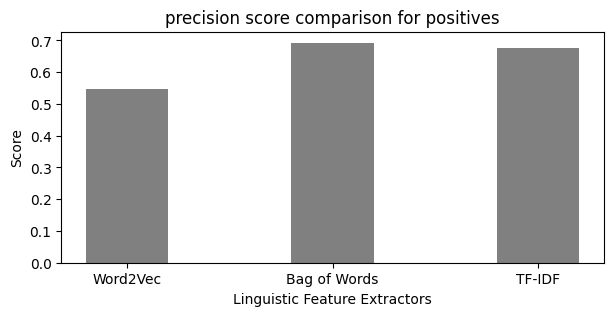

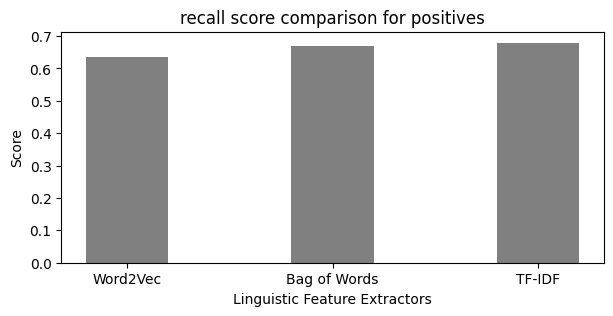

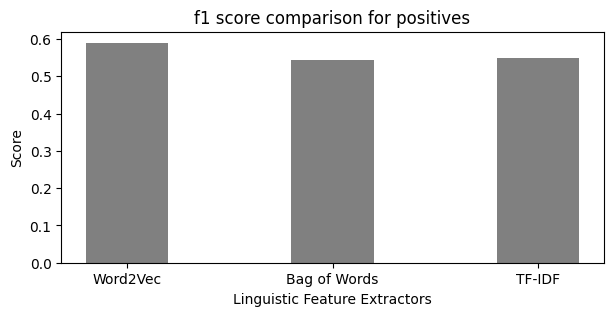

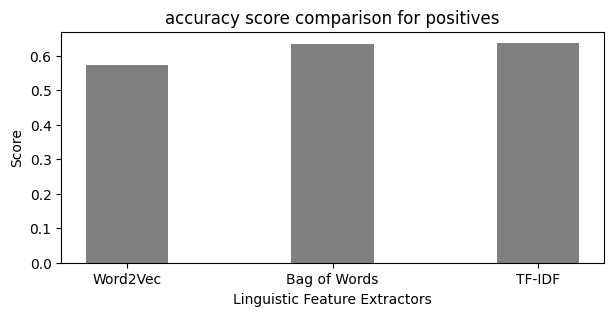

In [40]:
for classifier, classifier_name in zip(lc_classifiers, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(linguistic_features_names, classifier, color ='gray', width = 0.4)
    plt.xlabel("Linguistic Feature Extractors")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

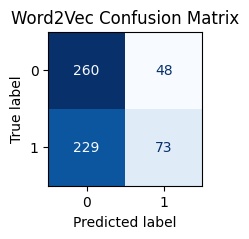

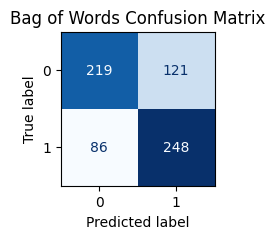

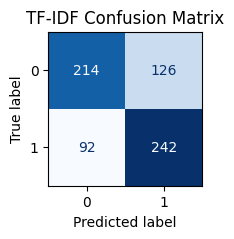

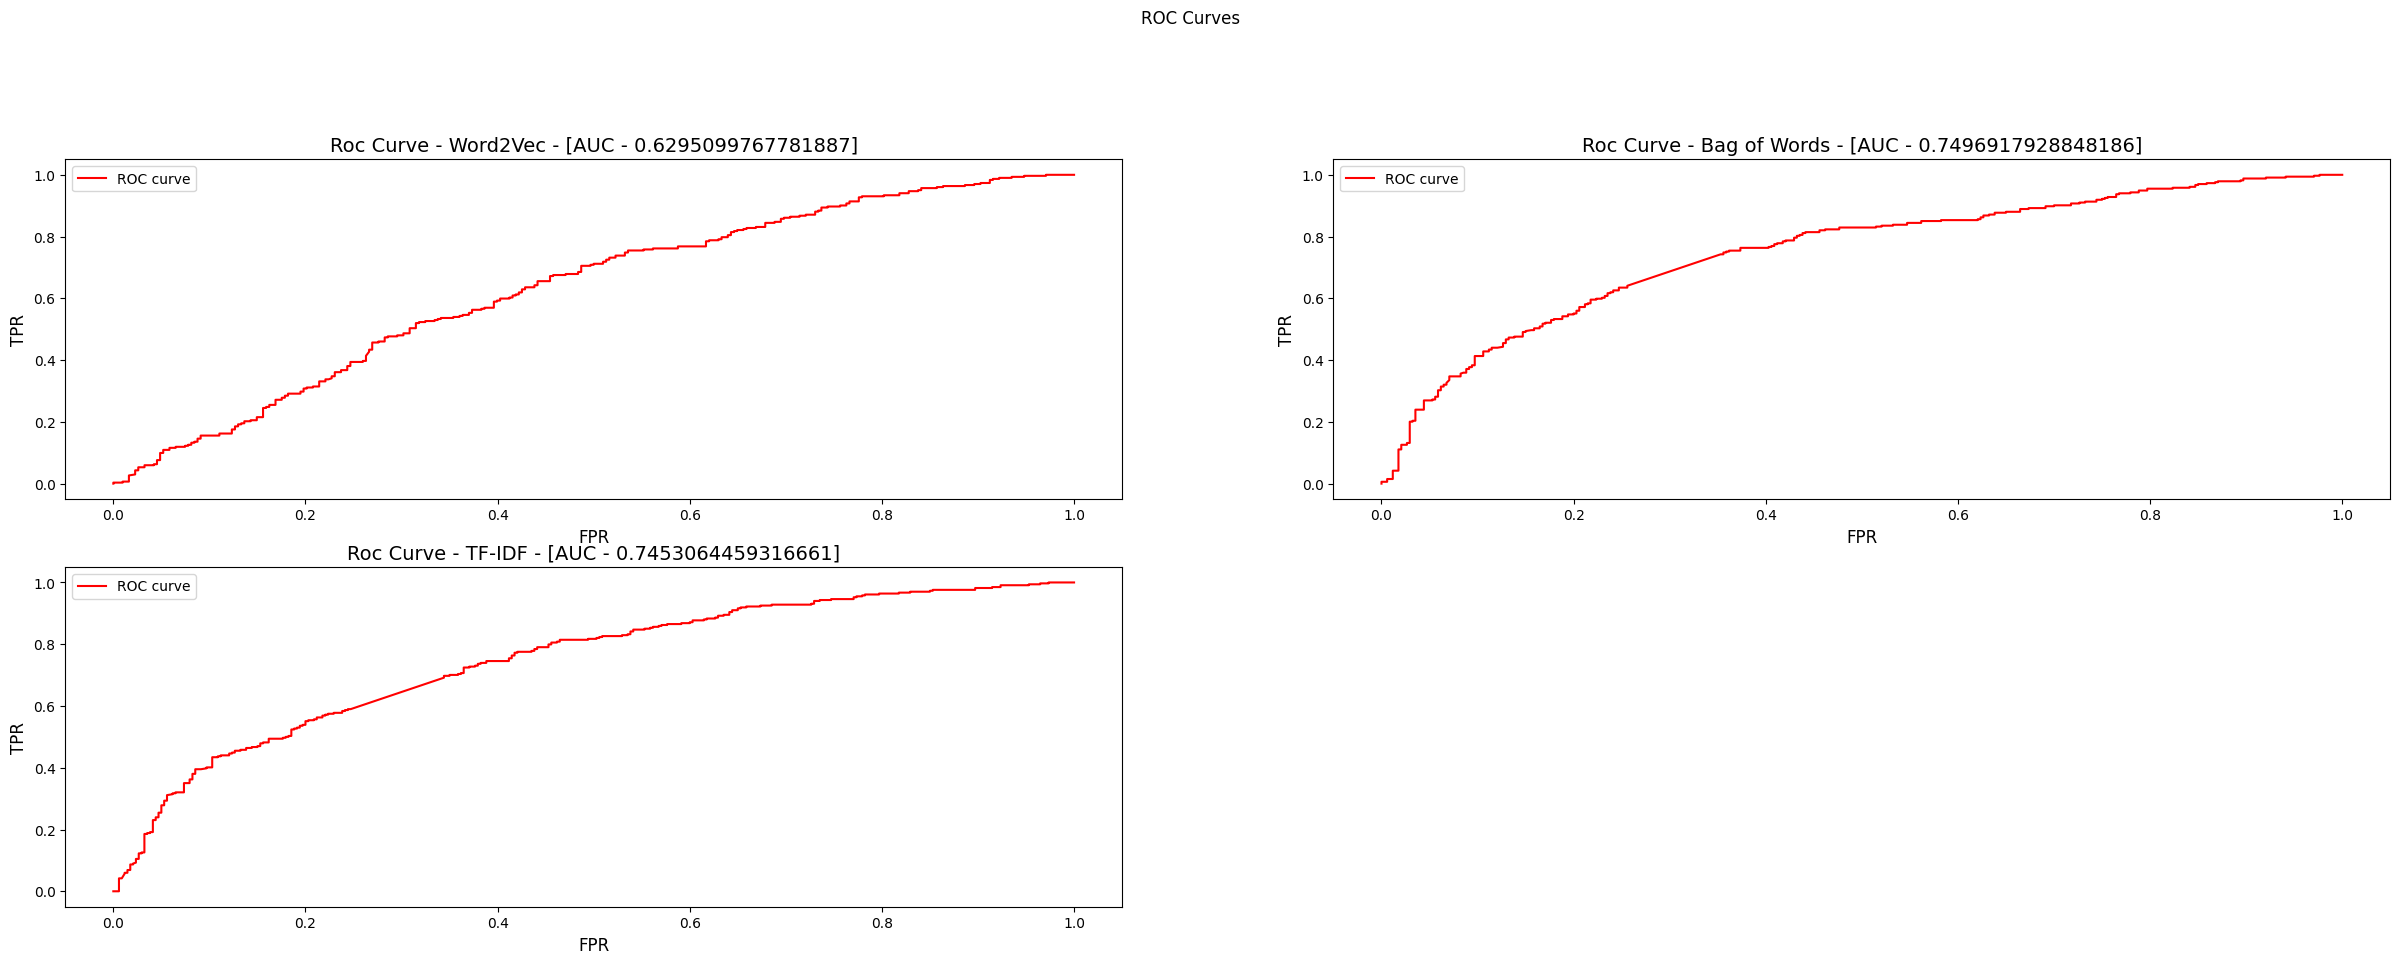

In [41]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{linguistic_feature} Confusion Matrix")

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, lc_pred, lc_pred_proba, lf_y_test):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, lc_pred, lc_pred_proba, lf_y_test):
    fpr, tpr, thresholds = roc_curve(np.array(y_test), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {linguistic_feature} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### SVM

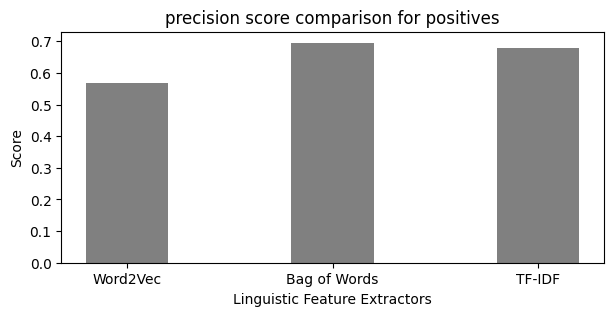

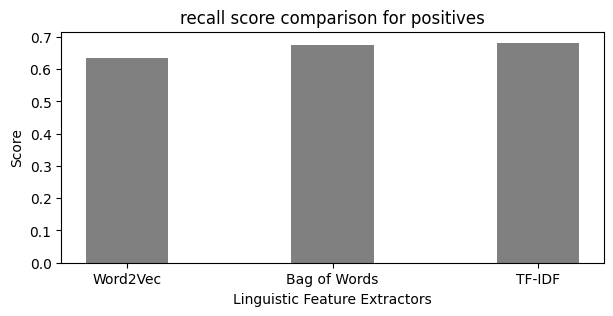

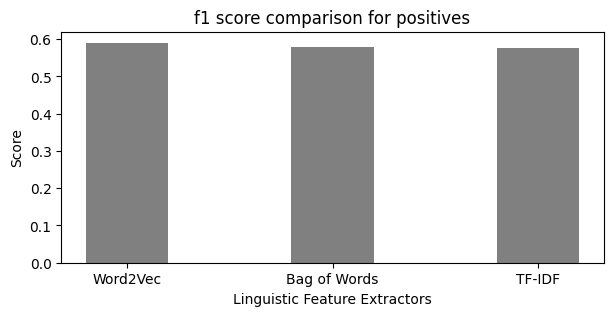

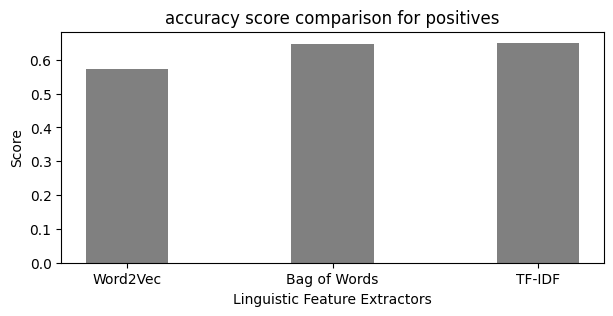

In [42]:
for classifier, classifier_name in zip(svc_classifiers, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(linguistic_features_names, classifier, color ='gray', width = 0.4)
    plt.xlabel("Linguistic Feature Extractors")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

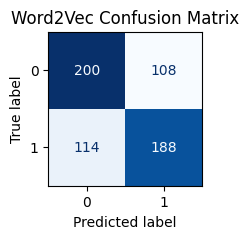

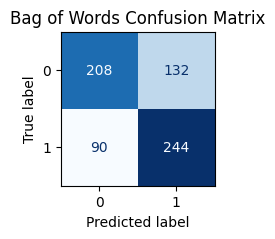

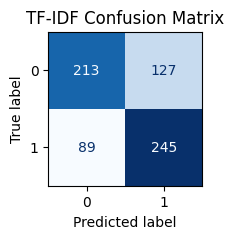

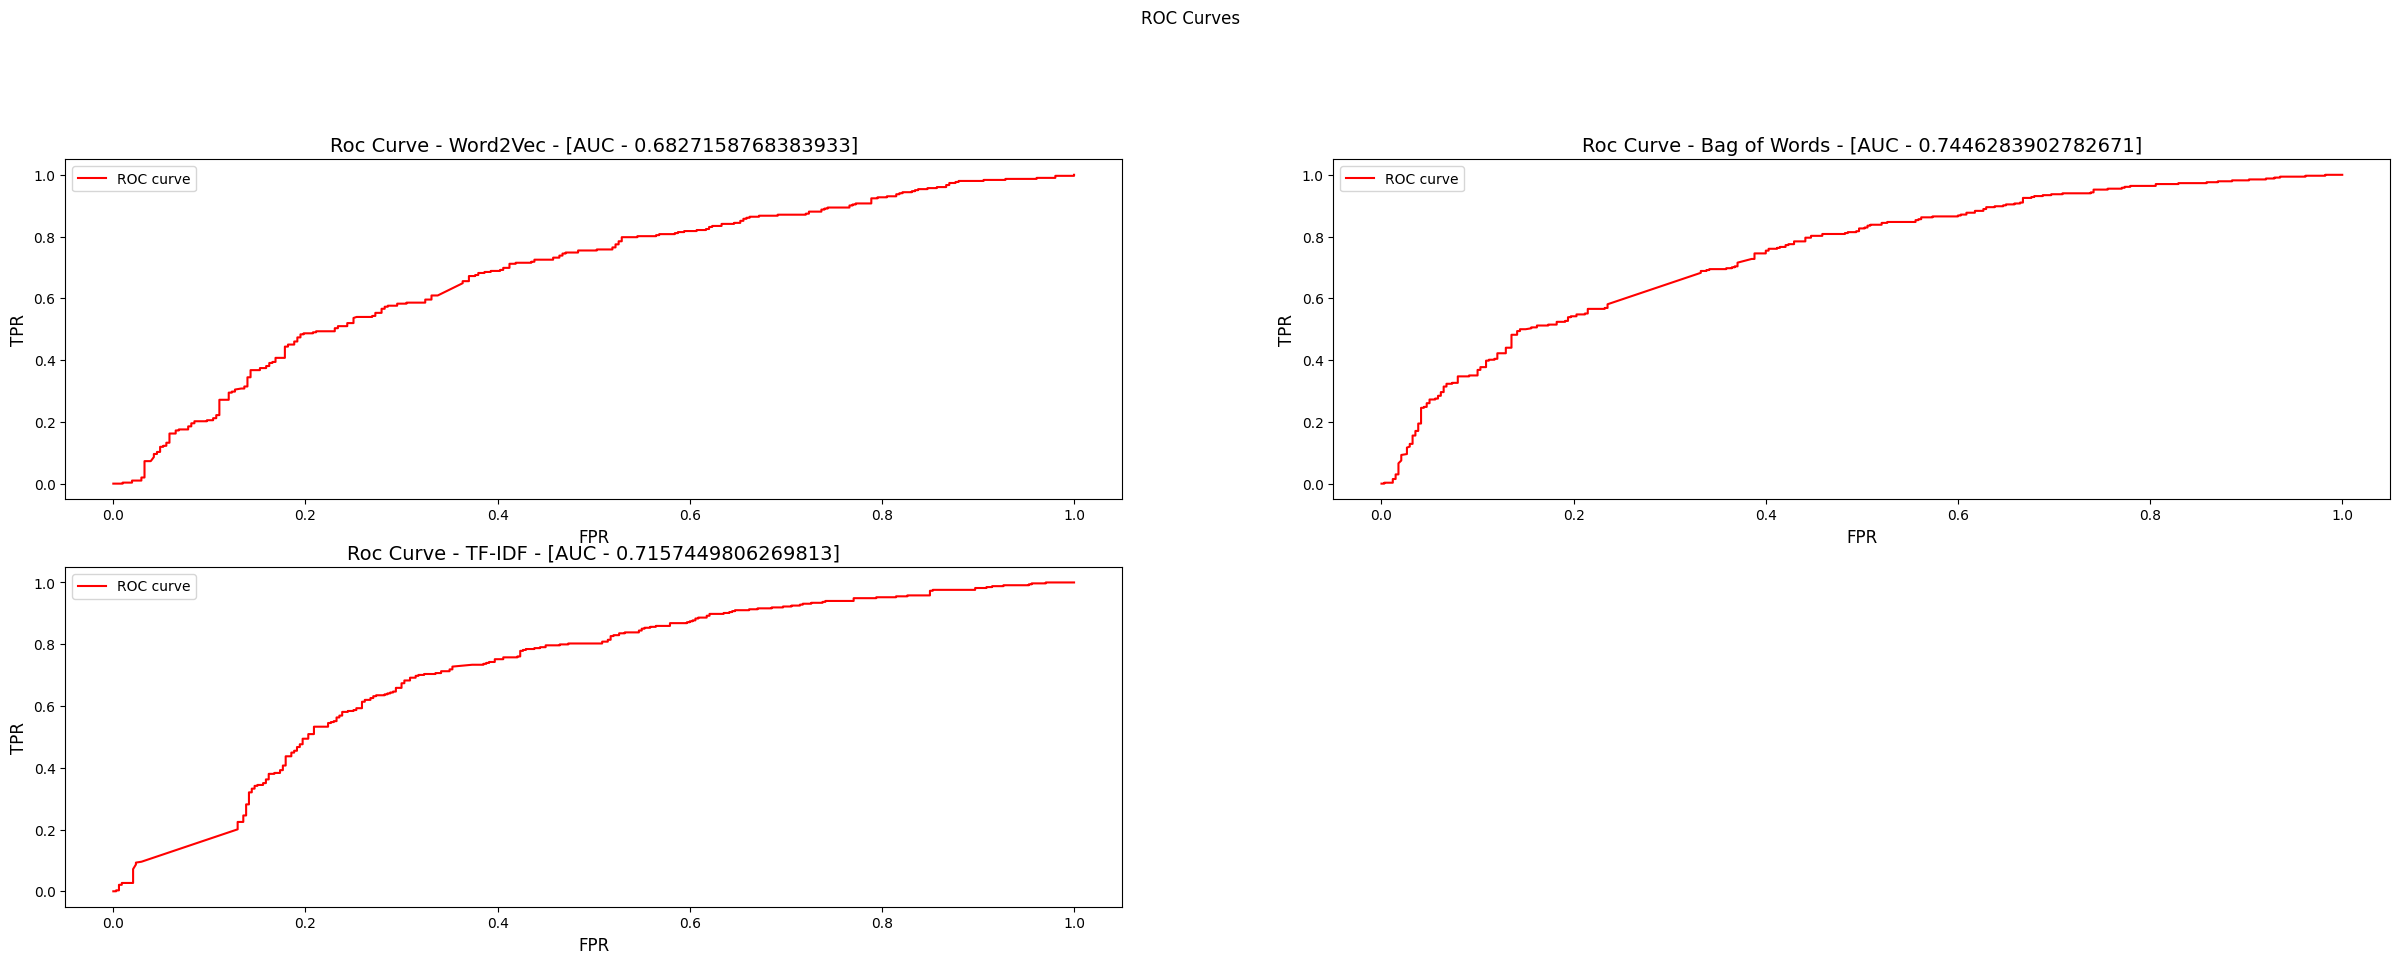

In [43]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{linguistic_feature} Confusion Matrix")

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, svc_pred, svc_pred_proba, lf_y_test):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, svc_pred, svc_pred_proba, lf_y_test):
    fpr, tpr, thresholds = roc_curve(np.array(y_test), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {linguistic_feature} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### Naive Bayes

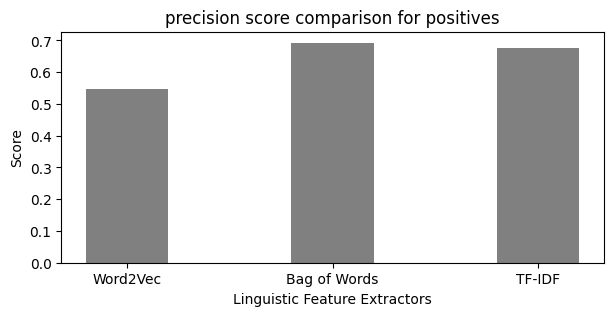

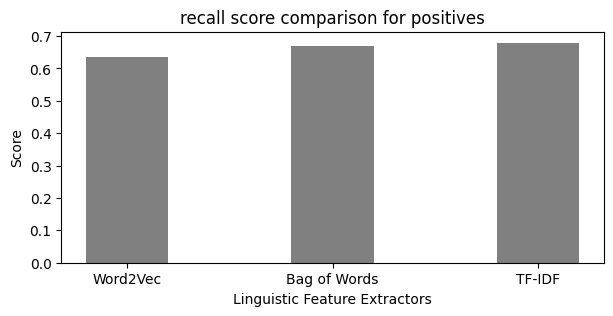

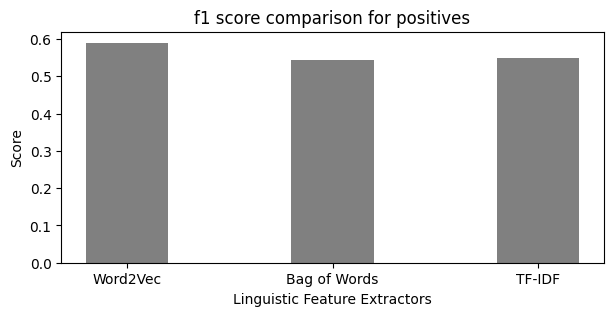

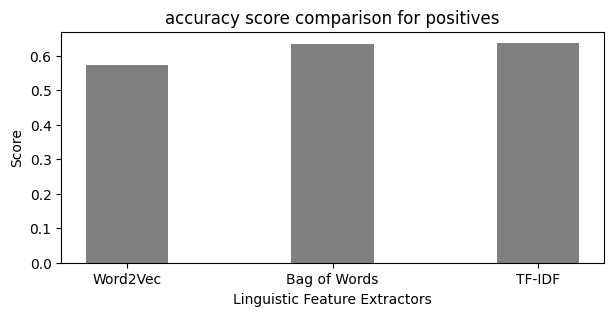

In [44]:
for classifier, classifier_name in zip(nbc_classifiers, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(linguistic_features_names, classifier, color ='gray', width = 0.4)
    plt.xlabel("Linguistic Feature Extractors")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

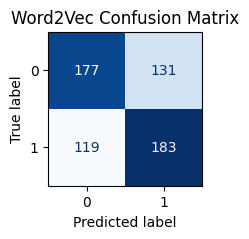

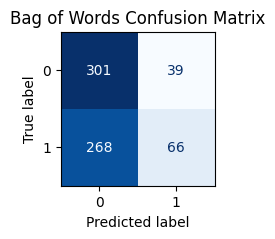

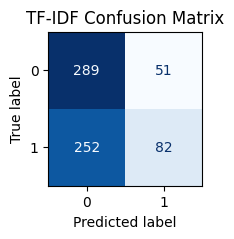

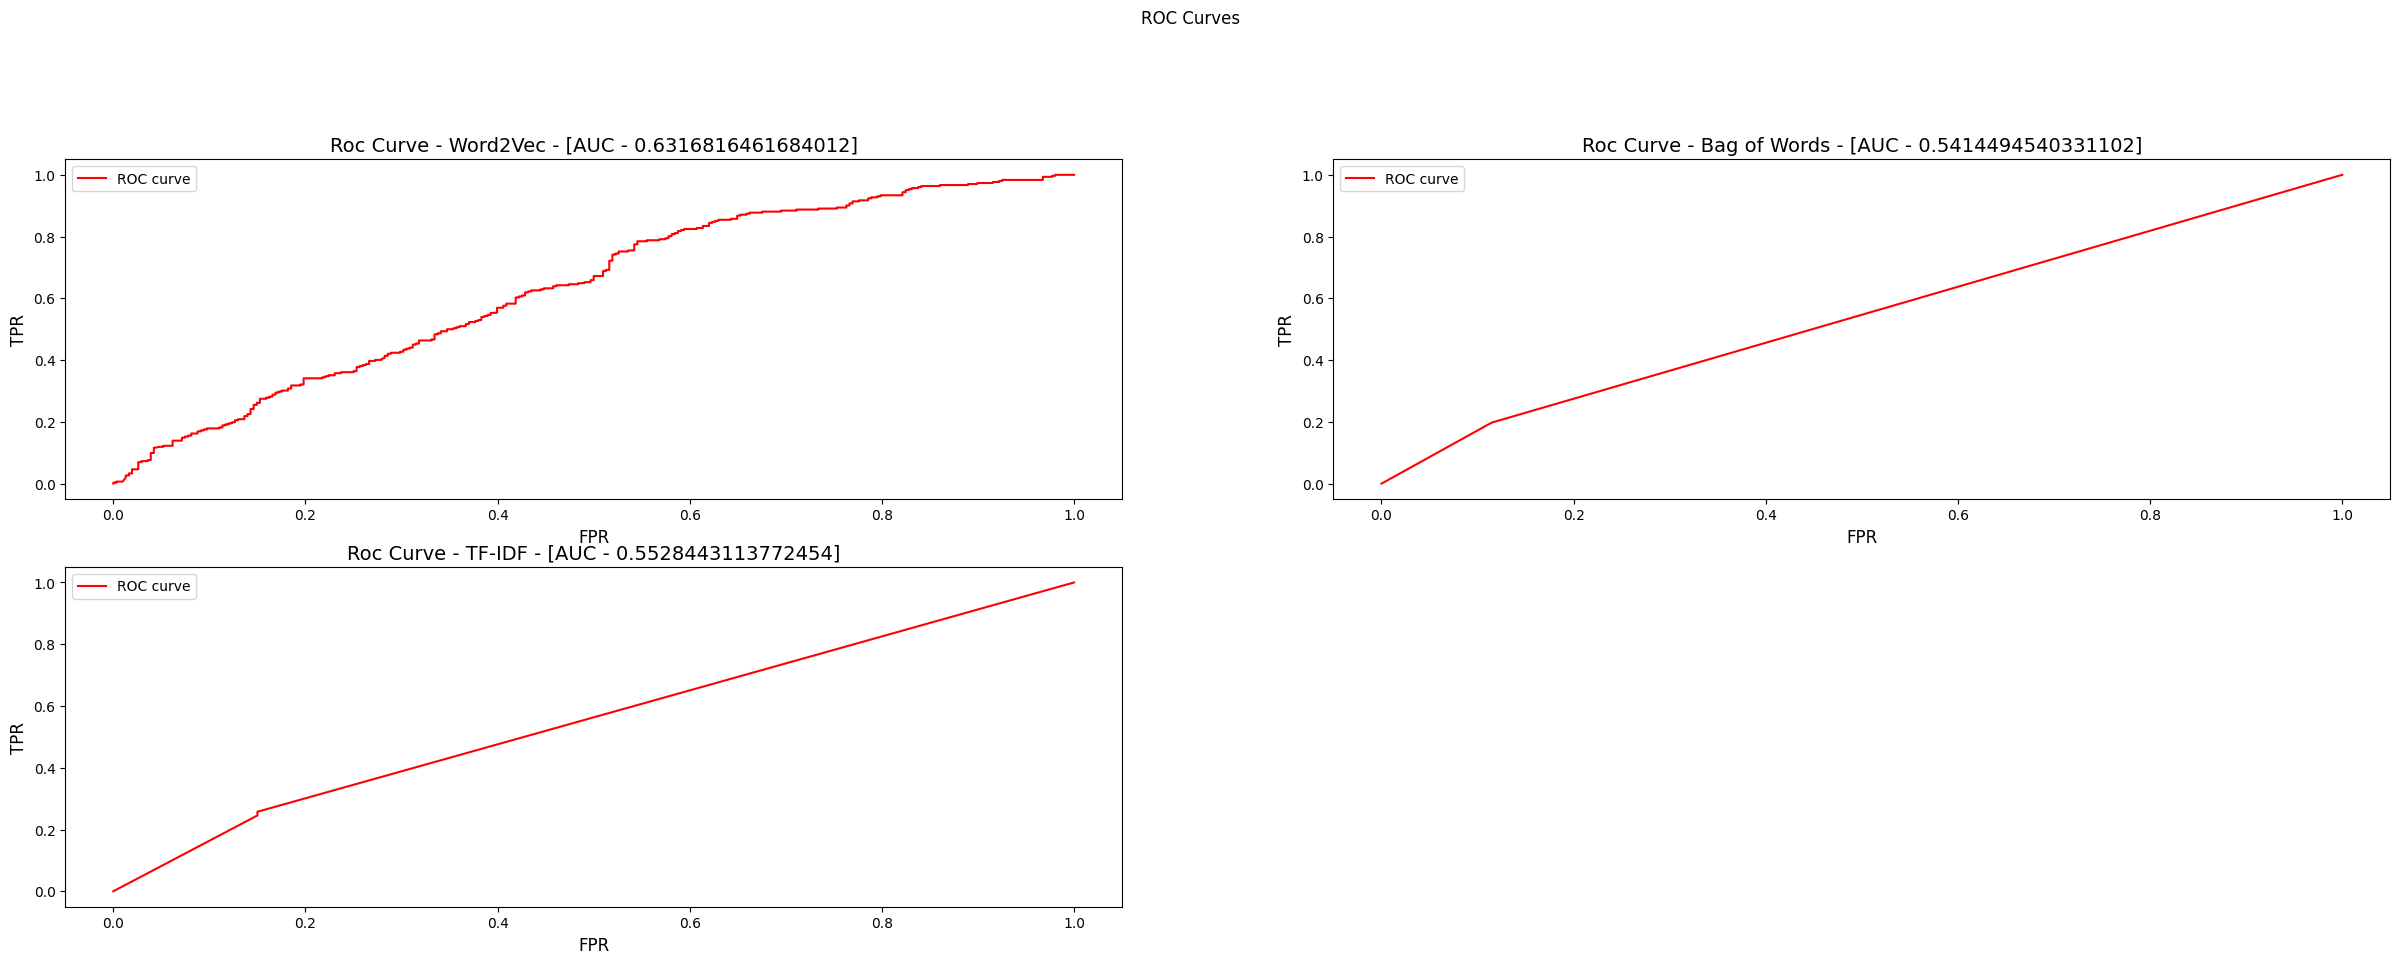

In [45]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{linguistic_feature} Confusion Matrix")

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, nbc_pred, nbc_pred_proba, lf_y_test):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, nbc_pred, nbc_pred_proba, lf_y_test):
    fpr, tpr, thresholds = roc_curve(np.array(y_test), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {linguistic_feature} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### Random Forest

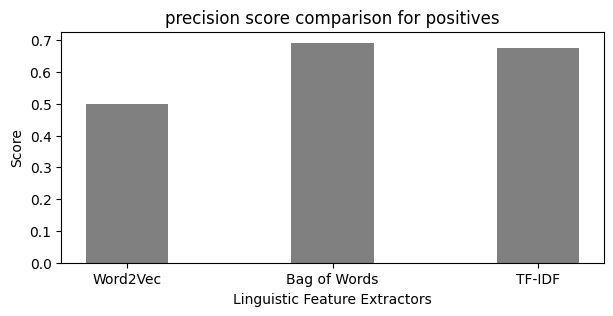

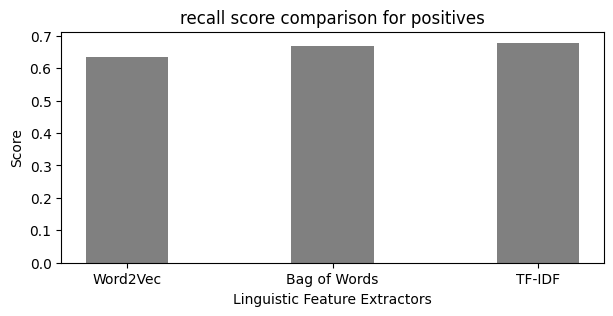

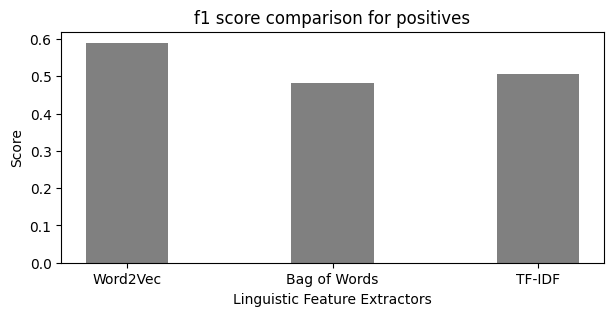

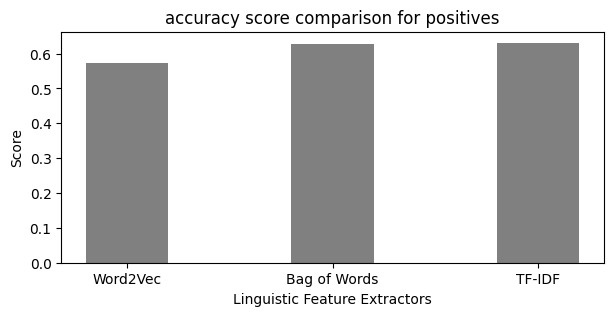

In [46]:
for classifier, classifier_name in zip(rfc_classifiers, classifier_names):
    fig = plt.figure(figsize = (7, 3))
    plt.bar(linguistic_features_names, classifier, color ='gray', width = 0.4)
    plt.xlabel("Linguistic Feature Extractors")
    plt.ylabel("Score")
    plt.title(f"{classifier_name} comparison for positives")
    plt.show()

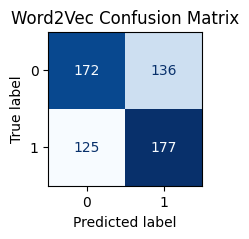

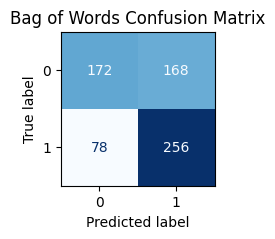

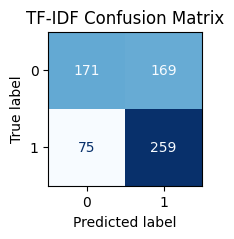

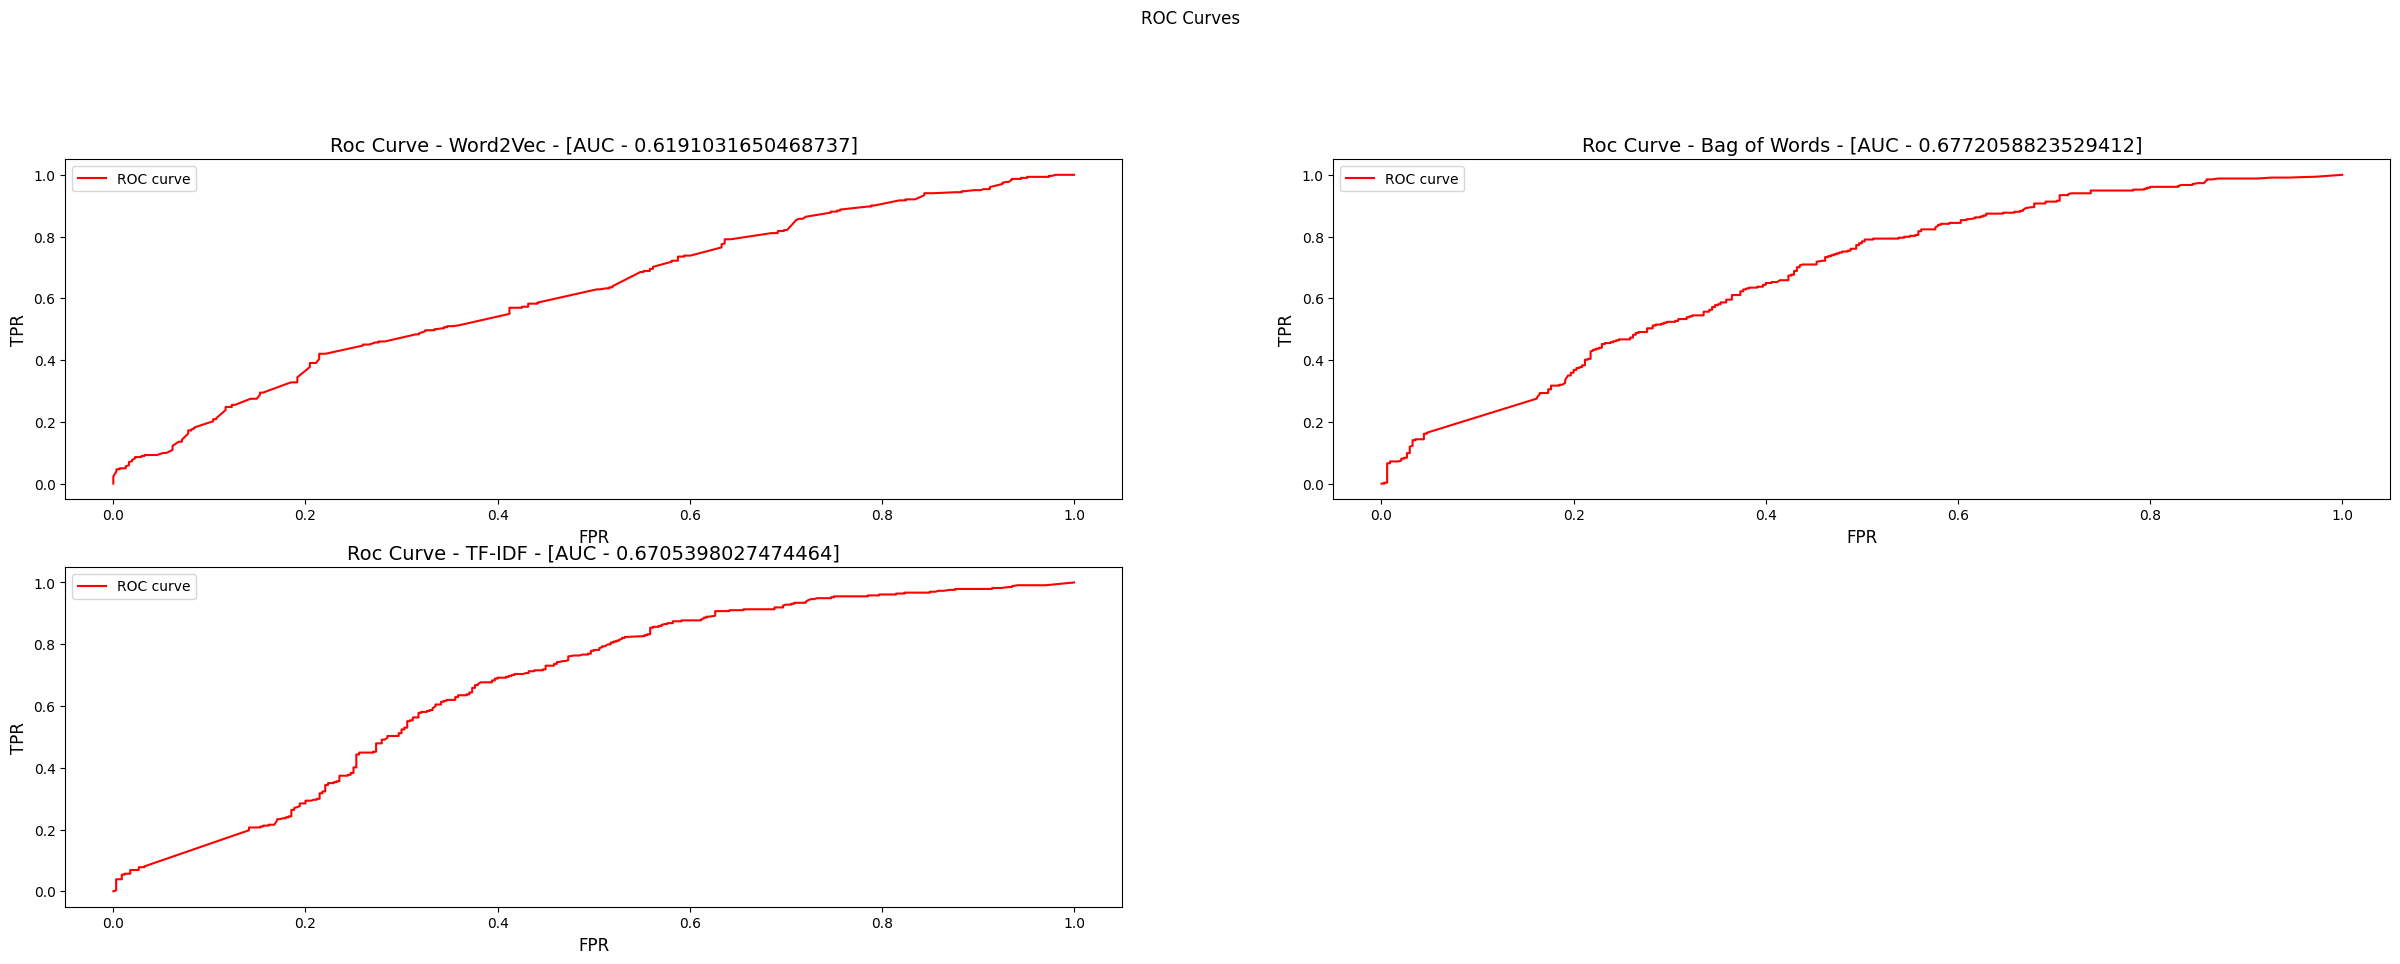

In [47]:
plot = 1
def display_plot(disp):
    fig, ax = plt.subplots(figsize=(2,2))
    disp.plot(
        include_values=True,
        cmap='Blues',
        colorbar=False,
        ax=ax
    )
    disp.ax_.set_title(f"{linguistic_feature} Confusion Matrix")

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, rfc_pred, rfc_pred_proba, lf_y_test):
    disp = ConfusionMatrixDisplay(confusion_matrix(np.array(y_test).ravel(), prediction))
    display_plot(disp)
    

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for linguistic_feature, prediction, pred_proba, y_test in zip(linguistic_features_names, rfc_pred, rfc_pred_proba, lf_y_test):
    fpr, tpr, thresholds = roc_curve(np.array(y_test), pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {linguistic_feature} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()